#Deepfake Audio Classification using CNN

Imports.

In [1]:
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from torchvision.transforms.functional import to_pil_image
from PIL import Image
import os
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.optim as optim
import torch.utils.data
import random

import torch.nn.functional

from sklearn.metrics import confusion_matrix
import seaborn as sns

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Current device:', device)

if device.type == 'cuda':
    print('GPU Name:', torch.cuda.get_device_name(0))
    print('Total GPU Memory:', round(torch.cuda.get_device_properties(0).total_memory/1024**3,1), 'GB')

Current device: cuda
GPU Name: NVIDIA GeForce RTX 2060
Total GPU Memory: 6.0 GB


Loading the dataset.

In [3]:
class CustomAudioDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.class_names = ["original", "deepfake"]
        self.samples = self._load_samples()

    def _load_samples(self):
        samples = []

        for dir_name in os.listdir(self.root_dir):
            dir_path = os.path.join(self.root_dir, dir_name)

            # Determine if the sample is "original" or "deepfake"
            label = 1 if dir_name.endswith("original") else 0

            samples.append((dir_path, label))

        return samples

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        try:
            dir_path, label = self.samples[idx]

            images = []

            for img_name in sorted(os.listdir(dir_path)):
                # Check if the image is from the right channel and frequency
                if "right-channel-frequency" in img_name:
                    img_path = os.path.join(dir_path, img_name)
                    img = Image.open(img_path).convert('RGB')

                    if self.transform:
                        img = self.transform(img)

                    images.append(img)

            # Concatenate images along the channel dimension (dimension 0)
            sample = torch.cat(images, dim=0)

            return sample, label

        except Exception as e:
            print(f"Error processing sample at index {idx}: {str(e)}")
            return None, None

# Path to the dataset
dataset_path = r'C:\onur_bilkent\CS464ProjectLocal\First Split'

# Define transformations to be applied to the images
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize the image
    transforms.ToTensor(),           # Convert to tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize
])

# Create custom datasets for train, test, and validation
train_dataset = CustomAudioDataset(root_dir=os.path.join(dataset_path, 'train'), transform=transform)
test_dataset = CustomAudioDataset(root_dir=os.path.join(dataset_path, 'test'), transform=transform)
val_dataset = CustomAudioDataset(root_dir=os.path.join(dataset_path, 'validation'), transform=transform)

print(f"{len(val_dataset)}")
# Balance the dataset by selecting the same number of samples randomly from both classes
original_samples = [sample for sample in train_dataset.samples if sample[1] == 1]
deepfake_samples = [sample for sample in train_dataset.samples if sample[1] == 0]

# Ensure equal number of samples without duplicates
min_samples = min(len(original_samples), len(deepfake_samples))
balanced_original_samples = random.sample(original_samples, min_samples)
balanced_deepfake_samples = random.sample(deepfake_samples, min_samples)

# Combine balanced samples
balanced_samples = balanced_deepfake_samples + balanced_original_samples
random.shuffle(balanced_samples)

# Replace the original samples in the dataset
train_dataset.samples = balanced_samples

# Print the number of samples for each class in the balanced dataset
num_original_samples = sum(1 for sample in balanced_samples if sample[1] == 1)
num_deepfake_samples = sum(1 for sample in balanced_samples if sample[1] == 0)

print(f"Number of original samples: {num_original_samples}")
print(f"Number of deepfake samples: {num_deepfake_samples}")

# Create DataLoader
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)

# Example: Retrieve a single sample from the training dataset
sample, label = train_dataset[0]
print("Sample Shape:", sample.shape)
print("Label:", label)


584
Number of original samples: 599
Number of deepfake samples: 599
Sample Shape: torch.Size([3, 224, 224])
Label: 1


Print and check a sample from the loaded images.

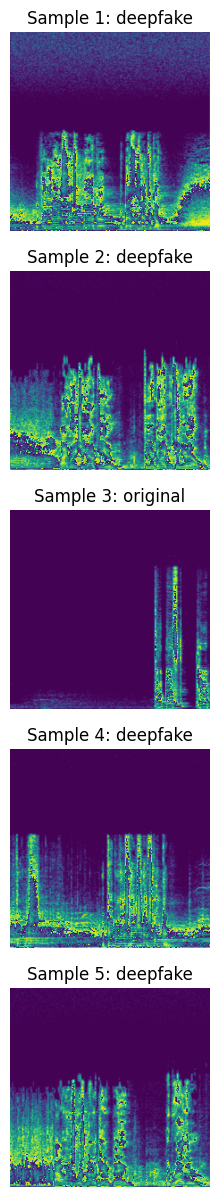

In [4]:
# Number of samples to visualize
num_samples = 5

# Create subplots for each sample
fig, axes = plt.subplots(num_samples, 1, figsize=(12, 3 * num_samples))

# Visualize each sample
for s in range(num_samples):
    images, label = train_dataset[s]

    img_pil = to_pil_image(images[0])

    axes[s].imshow(img_pil)
    axes[s].axis('off')
    axes[s].set_title(f"Sample {s+1}: {train_dataset.class_names[label]}") # Show the corresponding class label

plt.show()

Create the CNN model.

In [5]:
class ModelCNN(nn.Module):
    def __init__(self, dropout_rate=0.5):
        super(ModelCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(32 * 56 * 56, 64)
        self.fc2 = nn.Linear(64, 2)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)
        x = x.view(-1, 32 * 56 * 56)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        # Sigmoid for binary classification
        x = torch.sigmoid(x)
        return x


In [6]:
# Function for model training
def train_model(model, train_dataloader, criterion, optimizer, num_epochs, batch_size):
    # Update the batch size in DataLoader
    train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for inputs, labels in train_dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        epoch_loss = running_loss / len(train_dataloader)
        print(f'Epoch {epoch + 1}/{num_epochs}, Training Loss: {epoch_loss}')

    return model

# Instantiate the CNN model
model_default = ModelCNN()

model_default.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_default.parameters(), lr=0.0001)

# Train the model with default parameters
num_epochs_default = 15
train_model(model_default, train_dataloader, criterion, optimizer, num_epochs=num_epochs_default, batch_size=32)

# Evaluate the model on the test set with default parameters
model_default.eval()
correct_default = 0
total_default = 0

with torch.no_grad():
    for inputs, labels in test_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model_default(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total_default += labels.size(0)
        correct_default += (predicted == labels).sum().item()

accuracy_default = correct_default / total_default
print(f'Test Accuracy with Default Parameters: {accuracy_default * 100:.5f}%')

Epoch 1/15, Training Loss: 0.692195945664456
Epoch 2/15, Training Loss: 0.6687883468050706
Epoch 3/15, Training Loss: 0.6458420737793571
Epoch 4/15, Training Loss: 0.6129528754635861
Epoch 5/15, Training Loss: 0.5933329494375932
Epoch 6/15, Training Loss: 0.5633917074454459
Epoch 7/15, Training Loss: 0.5476688962233695
Epoch 8/15, Training Loss: 0.532201487767069
Epoch 9/15, Training Loss: 0.5185675903370506
Epoch 10/15, Training Loss: 0.49807615499747426
Epoch 11/15, Training Loss: 0.48296186720070083
Epoch 12/15, Training Loss: 0.47195436138855784
Epoch 13/15, Training Loss: 0.4631991268772828
Epoch 14/15, Training Loss: 0.45821749615041835
Epoch 15/15, Training Loss: 0.44528700646601227
Test Accuracy with Default Parameters: 92.36884%




Hyperparameter Combination - LR: 0.001, Dropout: 0.2, Batch Size: 16, Epochs: 15
Epoch 1/15, Training Loss: 0.6892933885256449
Epoch 2/15, Training Loss: 0.6098541990915934
Epoch 3/15, Training Loss: 0.513371772368749
Epoch 4/15, Training Loss: 0.41867956161499026
Epoch 5/15, Training Loss: 0.3771633076667786
Epoch 6/15, Training Loss: 0.3537218526999156
Epoch 7/15, Training Loss: 0.3608779422442118
Epoch 8/15, Training Loss: 0.33900572260220846
Epoch 9/15, Training Loss: 0.33293163935343423
Epoch 10/15, Training Loss: 0.3307603092988332
Epoch 11/15, Training Loss: 0.331717088619868
Epoch 12/15, Training Loss: 0.32445293227831523
Epoch 13/15, Training Loss: 0.3234336054325104
Epoch 14/15, Training Loss: 0.3211504542827606
Epoch 15/15, Training Loss: 0.32320422848065694
Validation Loss: 0.33923702787708593
Validation Accuracy: 97.43151%
Test Accuracy: 97.45628%
Confusion Matrix:
[[540   6]
 [ 10  73]]


Hyperparameter Combination - LR: 0.001, Dropout: 0.2, Batch Size: 32, Epochs: 15
E

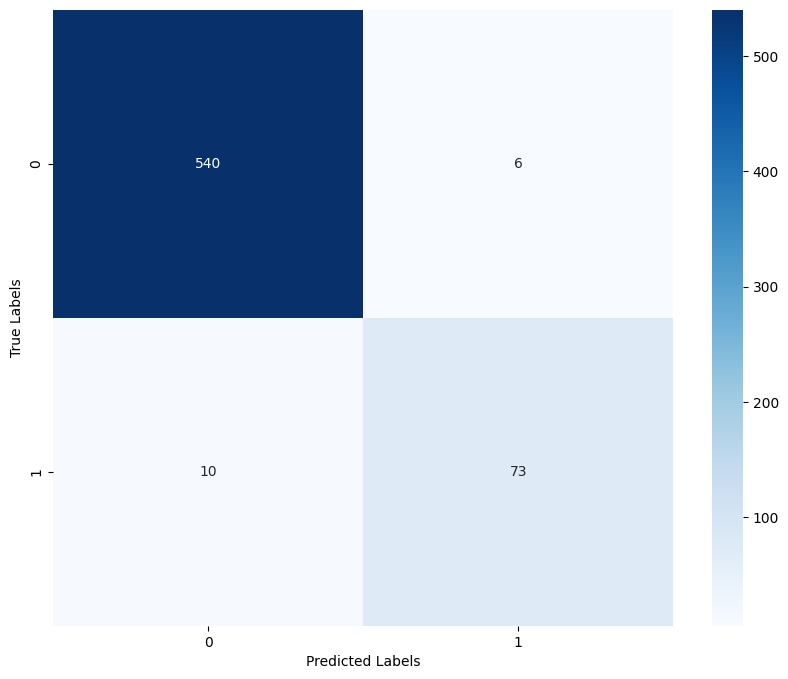

In [7]:
# Function for model validation
def validate_model(model, val_dataloader, criterion):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in val_dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        avg_val_loss = val_loss / len(val_dataloader)
        print(f"Validation Loss: {avg_val_loss}")
        val_accuracy = correct / total 
        print(f"Validation Accuracy: {val_accuracy * 100:.5f}%")

    return val_accuracy 

# Define hyperparameter grid
learning_rates = [0.001, 0.0001, 0.00001]
dropout_rates = [0.2, 0.5, 0.8]
batch_sizes = [16, 32, 64]
num_epochs_list = [15]

total_combinations = len(learning_rates) * len(dropout_rates) * len(num_epochs_list)
current_combination = 0

best_val_accuracy = 0.0
best_hyperparameters = {}
best_hyperparameters_test = {}

# Iterate over hyperparameter grid
for lr in learning_rates:
    for dropout_rate in dropout_rates:
        for batch_size in batch_sizes:
            for num_epochs in num_epochs_list:
                # Instantiate the CNN model
                model = ModelCNN(dropout_rate=dropout_rate)
                model.to(device)

                # Define loss function and optimizer
                criterion = nn.CrossEntropyLoss()
                optimizer = optim.Adam(model.parameters(), lr=lr)

                # Train the model
                print("\n")
                print(f'Hyperparameter Combination - LR: {lr}, Dropout: {dropout_rate}, Batch Size: {batch_size}, Epochs: {num_epochs}')
                
                # Adjust the batch size in DataLoader
                train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
                test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
                val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

                train_model(model, train_dataloader, criterion, optimizer, num_epochs=num_epochs, dropout_rate=dropout_rate, batch_size=batch_size)

                # Validate the model on the validation set
                val_accuracy_current = validate_model(model, val_dataloader, criterion)

            # Evaluate the model on the test set
            model.eval()
            correct = 0
            total = 0
            all_predictions = []
            all_labels = []

            with torch.no_grad():
                for inputs, labels in test_dataloader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    outputs = model(inputs)
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()

                    # Append predictions and labels to lists
                    all_predictions.extend(predicted.cpu().numpy())
                    all_labels.extend(labels.cpu().numpy())

            # Calculate the confusion matrix
            conf_matrix = confusion_matrix(all_labels, all_predictions)

            # Calculate and print accuracy
            accuracy = correct / total
            print(f'Test Accuracy: {accuracy * 100:.5f}%')

            # Print the confusion matrix
            print("Confusion Matrix:")
            print(conf_matrix)

            # Update best hyperparameters if current combination is better
            if val_accuracy_current > best_val_accuracy:
                best_val_accuracy = val_accuracy_current 
                best_hyperparameters = {
                    'Learning Rate': lr,
                    'Dropout Rate': dropout_rate,
                    'Number of Epochs': num_epochs,
                    'Confusion Matrix for the Test Set': conf_matrix,
                    'Test Accuracy': accuracy,
                }


print("\n")
print(f'Overall Best Validation Accuracy: {best_val_accuracy}%')
print(f'Best Hyperparameter Combination:')
print(f'  Learning Rate (LR): {best_hyperparameters["Learning Rate"]}')
print(f'  Dropout Rate: {best_hyperparameters["Dropout Rate"]}')
print(f'  Number of Epochs: {best_hyperparameters["Number of Epochs"]}')
print(f'  Test Accuracy: {best_hyperparameters["Test Accuracy"]}')
print(f"Confusion Matrix:")
print(f'{best_hyperparameters["Confusion Matrix for the Test Set"]}')
# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(best_hyperparameters["Confusion Matrix for the Test Set"], annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()
